In [ ]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from tqdm import tqdm  

import geopandas as gpd  
import cartopy.crs as ccrs  
import us # need to install
from matplotlib.patches import Patch 
from matplotlib.lines import Line2D  
from matplotlib.font_manager import FontProperties
import matplotlib.patches as mpatches

# notebook_dir = Path.cwd()
# project_root = notebook_dir.parent
# os.chdir(project_root)

# plt.switch_backend('pgf') # change to 'pgf' for LaTeX export # use inline for Jupyter Notebook
%matplotlib inline 

plt.rcParams.update({ 
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
})

# %config InlineBackend.print_figure_kwargs={'bbox_inches': None}
# plt.style.use(['default'])
seed = 82


In [2]:
# Color settings:
color_palette = sns.color_palette("colorblind")

CB_color_cycle = [ # colorblind friendly colors but pretty
    '#56B4E9', '#CC79A7', '#D55E00', 
    '#009E73', '#984ea3', '#999999', 
    '#e41a1c', '#dede00']

party_colors = {
    'All Republican': 'lightcoral', 
    'All Democrat': 'cornflowerblue',
    'NaN': 'silver',
    'Mixed or Multiple Shifts': 'mediumpurple',
}

tech_colors = { # taken from PyPSA https://pypsa.readthedocs.io/en/latest/_static/pypsa_colors.html
    'Solar':                 '#FFD700',  # golden yellow
    'Wind':                  '#1E90FF',  # dodger blue
    'Storage':               '#FF8C00',  # dark orange
    'Other':                 '#A9A9A9',  # neutral gray
    'Batteries':             '#8A2BE2',  # blue‑violet
    'Cement':                '#696969',  # dim gray
    'Critical Minerals':     '#228B22',  # forest green
    'Fueling Equipment':     '#FF4500',  # orange‑red
    'Zero Emission Vehicles':'#32CD32',  # lime green
    'Carbon Management':     '#006400',  # dark green
    'Hydrogen':              '#00CED1',  # dark turquoise
    'SAF':                   '#FF6347',  # tomato (warm red)
    'Clean Fuels':           '#7CFC00',  # lawn green
    'Electrolyzers':         '#40E0D0',  # turquoise
    'Nuclear':               '#9400D3',  # dark violet
    'Iron & Steel':          '#B22222',  # firebrick (rust/red)
    'Pulp & Paper':          '#DEB887',  # burlywood (light brown)
}

In [3]:
actinvest = pd.read_csv('data/quarterly_actual_investment.csv', header=3)
socioecon = pd.read_csv('data/socioeconomics.csv', header=3)
manuf_meta = pd.read_csv('data/manufacturing_energy_and_industry_facility_metadata.csv', header=3)
fedinveststata = pd.read_csv('data/federal_actual_investment_by_state.csv', header=3)
fedinvestcat = pd.read_csv('data/federal_actual_investment_by_category.csv', header=3)
congress = pd.read_csv('data/congressional_district_actual_investment_manufacturing_energy_and_industry.csv', header=5)

In [4]:
# Combine the dataframes

def standardize_keys(df):
        df['state'] = df['state'].astype(str).str.strip().str.lower()
        df['quarter'] = df['quarter'].astype(str).str.strip()
        return df

def combine_data(df1, df2, df3):

    df1 = df1.rename(columns={'State': 'state'})
    df2 = df2.rename(columns={'State': 'state'})
    df3 = df3.rename(columns={'State': 'state'})

    df1 = standardize_keys(df1)
    df2 = standardize_keys(df2)
    df3 = standardize_keys(df3)

    df3 = df3.drop(columns=["Population", "State GDP (Annualized)"], errors='ignore')
    
    unique_keys = df1[['state', 'quarter']].drop_duplicates()
    df2 = unique_keys.merge(df2, on=['state', 'quarter'], how='left')
    df3 = unique_keys.merge(df3, on=['state', 'quarter'], how='left')
    
    merged_df = df1.merge(df2, on=['state', 'quarter'], how='left')
    merged_df = merged_df.merge(df3, on=['state', 'quarter'], how='left')

    for i, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Updating missing values"):
        empty_columns = row[row.isna()].index.tolist()

        for col in empty_columns:
            if pd.isna(row[col]):
                state = row['state']
                quarter = row['quarter']
                matching_row = df3[(df3['state'] == state) & (df3['quarter'] == quarter)]
                if not matching_row.empty:
                    merged_df.at[i, col] = matching_row.iloc[0][col]
                else:
                    print(f"Warning: No matching row found in df3 for state {state} and quarter {quarter}.")

    return merged_df

merged = combine_data(congress, socioecon, fedinveststata)

Updating missing values: 100%|██████████| 7668/7668 [00:03<00:00, 2501.04it/s]


# Data Exploration

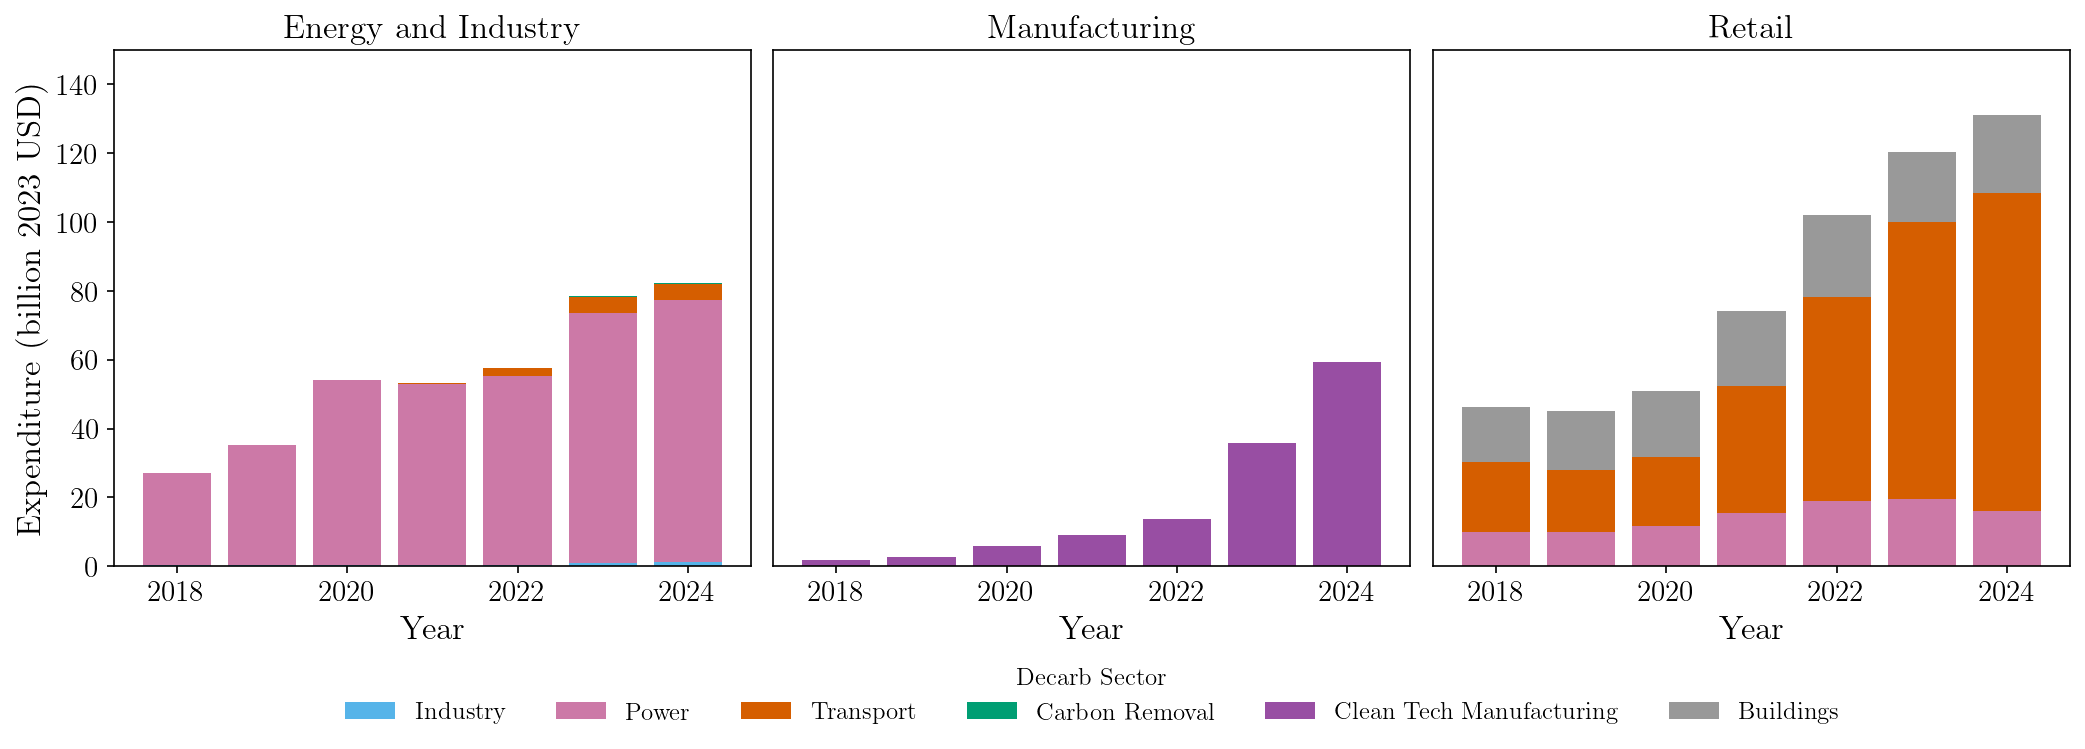

In [5]:
# Estimated energy and industry investment by segment over time
actinvest["Segment"] = actinvest["Segment"].str.replace(" ", "_") 
actinvest["Segment"] = actinvest["Segment"].str.lower()
actinvest['year'] = actinvest['quarter'].str.extract(r'(\d{4})').astype(int)
actinvest_byseg = actinvest.groupby(['Segment', 'year', 'Decarb_Sector'])['Estimated_Actual_Quarterly_Expenditure'].sum().reset_index()
actinvest_byseg['Estimated_Actual_Quarterly_Expenditure'] = actinvest_byseg['Estimated_Actual_Quarterly_Expenditure'] / 1000 # convert to billion USD

decarb_secs = actinvest_byseg['Decarb_Sector'].unique()
segment_names = actinvest_byseg['Segment'].unique()
fig, axes = plt.subplots(1, 3, figsize=(14, 5), dpi=150)
clean_segment_names = ['Energy and Industry', 'Manufacturing', 'Retail']

for i, segment in enumerate(segment_names):
    df_seg = actinvest_byseg[actinvest_byseg['Segment'] == segment]
    years = sorted(df_seg['year'].unique())
    bottom = np.zeros(len(years))

    for j, decarb in enumerate(decarb_secs):

        data = (
            df_seg[df_seg['Decarb_Sector'] == decarb]
            .groupby('year')['Estimated_Actual_Quarterly_Expenditure']
            .sum()
            .reindex(years, fill_value=0)
        )
        axes[i].bar(years, data, bottom=bottom, color=CB_color_cycle[j], label=decarb)
        bottom += data.values

    axes[i].set_title(clean_segment_names[i])
    axes[i].set_xlabel('Year')
    if i == 0:
        axes[i].set_ylabel('Expenditure (billion 2023 USD)')
    else:
        axes[i].set_yticks([])
    axes[i].set_ylim(0, 150)
    h, l = axes[0].get_legend_handles_labels()
fig.legend(handles=h, labels=l, title='Decarb Sector', bbox_to_anchor=(0.89, 0.13),  ncol=6, frameon=False)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('figures/Intro/actual_investment_by_segment.png', dpi=150)
plt.show()


### Pretty Maps

In [6]:
usmap = gpd.read_file("data/us_geospatial/us-states.json")
usmap = usmap[~usmap['id'].isin(['15', '02', '72'])].reset_index() # Remove Alaska, Hawaii, and Puerto Rico
usmap["state"] = np.ones(len(usmap))
stateindex = usmap.columns.get_loc("state")

for i, row in usmap.iterrows():
    state = row['name']
    state = state.lower()
    if state == "district of columbia":
        state_code = "DC"
    else:
        state = us.states.lookup(state)
        state_code = state.abbr
    usmap.iloc[i, stateindex] = state_code


/var/folders/2b/fjhstjgn55b7178k50j0fx7m0000gp/T/ipykernel_26068/1536699413.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'AL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  usmap.iloc[i, stateindex] = state_code


In [7]:
# Extracting dominant parties in each state

def gather_parties(row):
    return [
        row['US Senator 1: Party'].lower(),
        row['US Senator 2: Party'].lower(),
        row['US Representative Party'].lower()
    ]

def find_dominant_party(row):
    if row['rep_count'] > row['dem_count']:
        return 'Republican'
    elif row['dem_count'] > row['rep_count']:
        return 'Democrat'
    else:
        return 'Mixed' 
    
def classify_dominance(party_list):
    unique_parties = list(pd.Series(party_list).unique())
    
    if len(set(unique_parties)) == 1:
        if unique_parties[0] == "Republican":
            return "All Republican"
        elif unique_parties[0] == "Democrat":
            return "All Democrat"
        if unique_parties[0] == "Mixed":
            return "Mixed or Multiple Shifts"
        else:
            return "Mixed or Multiple Shifts"
    else:
        first_party = party_list[0]
        last_party = party_list[-1]
        
        if first_party == "Republican" and last_party == "Democrat":
            return "Shifted R->D"
        
        elif first_party == "Democrat" and last_party == "Republican":
            return "Shifted D->R"
        
        else:
            return "Mixed or Multiple Shifts"

merged['year'] = merged['quarter'].str.extract(r'(\d{4})').astype(int)
political_subset = merged.groupby(
    ['state', 'year', 'quarter']
    )[['US Senator 1: Party', 'US Senator 2: Party', 'US Representative Party']].first()

political_subset['parties_list'] = political_subset.apply(gather_parties, axis=1)
political_subset_ex = political_subset.explode('parties_list')
political_subset_ex = political_subset_ex.drop(columns=['US Senator 1: Party', 'US Senator 2: Party', 'US Representative Party'], errors='ignore')

party_counts = (
    political_subset_ex
    .groupby(['state', 'year', 'parties_list'])
    .size()
    .reset_index(name='count')
)

party_pivot = party_counts.pivot_table(
    index=['state', 'year'],
    columns='parties_list',
    values='count',
    aggfunc='sum',
    fill_value=0
).reset_index()

party_pivot.columns.name = None 
party_pivot = party_pivot.rename(columns={'democratic': 'dem_count', 'independent': 'ind_count', 'republican': 'rep_count'})

party_pivot['dominant_party'] = party_pivot.apply(find_dominant_party, axis=1)
grouped_party_dom = (
    party_pivot
    .groupby('state')['dominant_party']
    .agg(list)
    .reset_index(name='party_sequence')
)

grouped_party_dom['dominance_label'] = grouped_party_dom['party_sequence'].apply(classify_dominance)
grouped_party_dom.set_index('state', inplace=True)

In [8]:
# Preparing state-level investment data
investment = merged.groupby(['state'])['Estimated_Actual_Quarterly_Expenditure'].sum()

usmap['investment'] = np.zeros(len(usmap))
usmap['dominant_party'] = str(np.zeros(len(usmap)))
investindex = usmap.columns.get_loc('investment')
partyindex = usmap.columns.get_loc('dominant_party')

for i in range(len(usmap)):
    state = usmap.iloc[i]['state']
    state = state.lower()
    if state in investment.index:
        usmap.iloc[i, investindex] = investment[state]
    else:
        usmap.iloc[i, investindex] = 0
        print(f"{state} not found in investment data, filling 0.0")
    if state in grouped_party_dom.index:
        party = grouped_party_dom.loc[state, 'dominance_label']
        usmap.iloc[i, partyindex] = party
    else:
        usmap.iloc[i, partyindex] = "NaN"
        print(f"{state} not found in political data, filling NaN")
        
usmap['investment'] = usmap['investment'].astype(float)
usmap['investment'] = usmap['investment'].fillna(0)
usmap['dominant_party'] = usmap['dominant_party'].astype(str)
usmap['dominant_party'] = usmap['dominant_party'].str.replace("'", "")
usmap = usmap.drop(columns=['index', 'id'], errors='ignore')
usmap.set_index('state', inplace=True)

dc not found in investment data, filling 0.0
dc not found in political data, filling NaN


In [9]:
capex_state = manuf_meta.groupby(['State', 'Technology'])['Estimated_Total_Facility_CAPEX'].sum()
capex_state = pd.DataFrame(capex_state)
capex_state['capex_share'] = (capex_state['Estimated_Total_Facility_CAPEX']/capex_state
                              .groupby(level='State')['Estimated_Total_Facility_CAPEX']
                              .transform('sum')
)

In [ ]:
#plt.style.use(['default']) # doesn't work otherwise

plt.rcParams.update({ 
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16,
})


max_pie_size = 0.3
bubble_values = [100, 10000] 
bubble_scaling_factor = 130

if 'investment' not in usmap.columns:
    raise ValueError("The 'investment' column is missing in the 'usmap' DataFrame.")

inv = usmap['investment']
normalized = inv / inv.max()
pie_size_by_state = normalized * max_pie_size

usmap['centroid'] = usmap.geometry.centroid
usmap['centroid_x'] = usmap['centroid'].x
usmap['centroid_y'] = usmap['centroid'].y

fig = plt.figure(figsize=(14, 8), dpi=200)
ax  = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

plt.subplots_adjust(
    left=0.01,
    right=0.99,
    top=0.99,
    bottom=0.01
)

cm_font = FontProperties(
    family='serif',
)

usmap.plot(ax=ax,
           color=usmap['dominant_party'].map(party_colors),
           edgecolor='black')

for state, row in usmap.iterrows():
    x, y = row['centroid_x'], row['centroid_y']
    shares = capex_state.loc[state, 'capex_share']
    fracs = shares.values
    cols = [tech_colors[t] for t in shares.index]
    
    disp_pt = ax.transData.transform((x, y))
    fig_pt  = fig.transFigure.inverted().transform(disp_pt)
    
    pie_size = pie_size_by_state.loc[state]
    left   = fig_pt[0] - pie_size/2
    bottom = fig_pt[1] - pie_size/2
    
    pie_ax = fig.add_axes([left, bottom, pie_size, pie_size])
    pie_ax.pie(fracs,
               colors=cols,
               wedgeprops={'linewidth':0.3, 'edgecolor':'black'})
    pie_ax.set_aspect('equal')
    pie_ax.axis('off')

party_patches = [mpatches.Patch(color=c, label=l) for l, c in party_colors.items()]

# tech_patches = [mpatches.Patch(color=color, label=tech) for tech, color in tech_colors.items()]
tech_patches = [mpatches.Patch(color=color, label=tech.replace("&", "\\&")) for tech, color in tech_colors.items()]
legend_tech = ax.legend(
    handles=tech_patches,
    title='CAPEX Tech Share',
    loc='lower right',
    borderaxespad=0.5, 
    fontsize='medium',
    title_fontsize='large',
    ncol=1,
    frameon=False,
)
ax.add_artist(legend_tech)

max_val = usmap['investment'].max()
size_values = bubble_values
legend_marker_sizes = [np.sqrt(val / max_val) * bubble_scaling_factor for val in size_values]

size_handles = [
    Line2D([0], [0],
           marker='o',
           linestyle='',
           markerfacecolor='lightgray',
           markeredgecolor='black',
           markersize=ms)
    for ms in legend_marker_sizes
]

size_labels = [f'USD {val:,} million' for val in size_values]

legend_size = ax.legend(
    handles=size_handles,
    labels=size_labels,
    title='Total Investment',
    loc='center left',
    bbox_to_anchor=(0.01, 0.30),
    borderpad=0.3,
    labelspacing=2.0,
    handlelength=1.2,
    handletextpad=2.3,
    fontsize='medium',
    title_fontsize='large',
    frameon=False,
)
ax.add_artist(legend_size)

party_patches = [
    mpatches.Patch(color=c, label=l)
    for l, c in party_colors.items()
]

legend_party = ax.legend(
    handles=party_patches,
    loc='lower left',
    borderaxespad=0.5,
    title='Party Dominance (state color)',
    fontsize='medium',
    title_fontsize='large', # or 'large' or 'medium' 
    frameon=False,
)
ax.add_artist(legend_party)
for lg in (legend_tech, legend_size, legend_party):
    lg._legend_box.align = "left"

ax.set_frame_on(False)
# plt.savefig('figures/Intro/state_investment_pie.png', dpi=150)
# plt.show()

/var/folders/2b/fjhstjgn55b7178k50j0fx7m0000gp/T/ipykernel_26068/2376589175.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  usmap['centroid'] = usmap.geometry.centroid


In [11]:
merged.to_csv('data/posteda/merged_posteda.csv', index=False)